In [14]:
import tensorflow as tf
import numpy as np
import vgg19
import matplotlib.pyplot as plt
import utils

In [2]:
#img = tf.placeholder(tf.float32, [None, 224, 224, 3])
i_max = 1000
i_print = 10

#noise_center - noise_weight , noise_center + noise_weight
noise_min = 0.48
noise_max = 0.5

device = '/cpu:0'
show = True

#layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
style_gram_weight = [0.1, 0.3, 0.6, 0.9, 1.0]
style_histogram_weight = [0.2, 1.0]
gram_weight = 1.0
histogram_weight = 0.10

hist_range = [0.0,256.0]
hist_size = 100

In [3]:
def gram_matrix(F, N, M):
    Ft = tf.reshape(F, (M, N))
    if M < N:
        return tf.matmul(Ft,tf.transpose(Ft))
    else:
        return tf.matmul(tf.transpose(Ft), Ft)

In [4]:
def create_noise_image(width, height, noise_min = 0.0, noise_max = 1.0):
    image = np.random.uniform(noise_min,noise_max, (1, height, width, 3)).astype('float32')
    
    if(show == True):
        plt.imshow(image.reshape(height,width,3))
        plt.show()
    return image

In [5]:
def get_image(path):
    #load image
    img_input = utils.load_image(path)
    img = img_input.reshape((1, 224, 224, 3))
    
    #show image
    if(show == True):
        plt.imshow(img_input.reshape((224,224,3)))
        plt.show()
        
    return img

In [6]:
def get_gram_loss(target_layers, input_layers):
    gram_losses = []
    #go through layers
    for tl, il, w in zip(target_layers, input_layers, style_gram_weight):
        #get dimensions
        dimensions = tl.get_shape().as_list()
        size = dimensions[3]*dimensions[2]*dimensions[1]
        
        #get gram
        target_gram = gram_matrix(tl, dimensions[3], dimensions[2]*dimensions[1])
        input_gram = gram_matrix(il, dimensions[3], dimensions[2]*dimensions[1])
        
        #get losses
        gram_losses.append(gram_weight * w * tf.log(tf.reduce_sum(tf.square(target_gram - input_gram)) / size**2 ))
    
    #get gram_loss
    gram_loss = tf.reduce_sum(gram_losses)
    
    return gram_loss

In [7]:
def get_histogram_loss(target_layers, input_layers):
    histogram_losses = []
    #go through layers
    for tl, il, w in zip(target_layers, input_layers, style_histogram_weight):
        #get dimensions
        dimensions = tl.get_shape().as_list()
        size = dimensions[3]*dimensions[2]*dimensions[1]
        
        for featureIdx in range(dimensions[3]):
            tfeat = tf.slice(tl,[0,0,0,featureIdx],[1,dimensions[1],dimensions[2],1])
            ifeat = tf.slice(il,[0,0,0,featureIdx],[1,dimensions[1],dimensions[2],1])
            
            # Get the history matching of the texture on the input
            r_o = utils.feature_histogram_matching(tfeat, ifeat, [0.0, 256.0], 100)

            # loss = euclidean distance between the output and the histogram remapped output
            histogram_losses.append(tf.pow(tf.norm(tfeat - r_o), 2))
    
    #get total histogramloss
    histogram_loss = tf.reduce_sum(histogram_losses)
    
    #return histogram_loss
    return histogram_losses

/home/pnikray/projects/extern/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


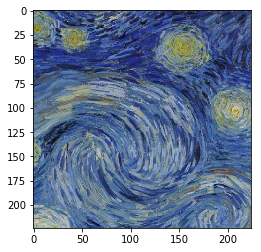

/home/pnikray/school/in4015/project/vgg19.npy
npy file loaded
build model started
build model finished: 0s


In [8]:
#create style data from style image
with tf.device(device):
    sess = tf.Session()
    
    #load style image
    input_img = get_image("./test_data/starrynight_small.jpg")  

    #input vgg
    input_image = tf.constant(input_img, tf.float32)
    
    #create style vgg()
    vgg = vgg19.Vgg19()    
    with tf.name_scope("style"):
        vgg.build(input_image)
    
    #layers
    style_layers = sess.run([vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1, vgg.conv4_1])
    
    #loop through layers and assign to style layers
    style_gram_layers = [tf.constant(style_layers[0]), tf.constant(style_layers[1]), tf.constant(style_layers[2]),
                    tf.constant(style_layers[3]), tf.constant(style_layers[4])]
    style_histogram_layers = [tf.constant(style_layers[5]), tf.constant(style_layers[4])]

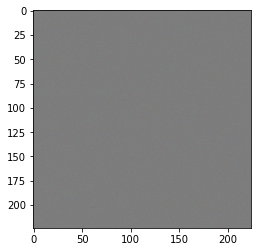

/home/pnikray/school/in4015/project/vgg19.npy
npy file loaded
build model started
build model finished: 0s


In [9]:
    #create target image
    target = tf.Variable((create_noise_image(224, 224, noise_min, noise_max)), tf.float32)
                 
    #create vgg  
    vgg = vgg19.Vgg19() 
    with tf.name_scope("target"):
        vgg.build(target)                 
    
    #target vgg
    target_gram_layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
    target_histogram_layers = [vgg.conv4_1, vgg.conv1_1]


In [16]:
    #get losses
    loss = 0
    
    loss += get_gram_loss(target_gram_layers, style_gram_layers)
    loss += get_histogram_loss(target_histogram_layers, style_histogram_layers)

In [ ]:
    #handlers
    optimizer = tf.train.AdamOptimizer(0.1)
    minimize = optimizer.minimize(tf.reduce_sum(loss))
    
    #init
    sess.run(tf.global_variables_initializer())
    
    #print(sess.run(loss))
    

In [ ]:
    for i in range(i_max):
        
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            #optimize step
        sess.run(minimize)
        #clip
        target = tf.maximum(tf.minimum(target,1),0)
        
        progress = ((i+1)%i_print)/i_print*100
        if(round(progress) % 10 == 0):
            print(progress, end = '% ')
            print(' ', end = '')
        
        if((i+1) % i_print == 0):
            
            #print loss
            #print(sess.run(target_layers, feed_dict = feed))
            print('')
            print(round((i+1)/i_print))
            print(sess.run(loss))

            #show image
            if(show == True):
                plt.imshow(sess.run(tf.reshape(target,(224,224,3))))
                plt.show()

    
